# Métodos Computacionais em Engenharia (FIS3022)
## Exame da época normal  (21 de Junho de 2022)

Devem responder às questões no próprio notebook, que devem gravar com um nome que inclua o vosso nome (primeiro e último) e número mecanográfico.  O notebook resultante deve, no mínimo, correr sem alterações, produzindo todos os resultados pedidos. Não usem módulos não-standard (se eu não tiver, não corre, nota é zero). Podem/devem também fazer comentários no notebook. Os códigos devem ser profusamente comentados.

Podem consultar os notebooks das aulas, bem como procurar ajuda sobre comandos python. Buscas sobre o tema do problema **NÃO** são permitidas, e se o fizerem a prova será anulada. O mesmo acontece se o código tiver evidentes parecenças com códigos publicados na Web.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy.linalg
from scipy import linalg

### Descrição do problema
Um médico administra uma injecção intramuscular a um paciente com uma reacção alérgica severa. A injecção demora um total de $T=5\textrm{ s}$ a ser administrada.  Considere que quando termina a aplicação o produto químico se espalhou por uma distância de $2.5\textrm{ cm}$ (consideramos o problema a 1d), com uma concentração inicial $C_0$ (que supomos constante).
 Seja a difusividade do medicamento $D=0.0075\textrm{ m}^2/\textrm{s}^{-1}$. Pretendemos determinar a concentração do medicamento no músculo, $75\textrm{ s}$ mais tarde.

a) Vamos supôr a veia um domínio unidimensional. Escreva a equação que descreve a evolução da concentração, $C(x,t)$, no tempo e no espaço. Adimencionalize (ou escolha unidades apropriadas) de modo a que não tenha que usar números grandes ou pequenos nos seus cálculos.

A evolução da concentração do medicamento $C(x,t)$ no tempo e no espaço será descrita por uma equação do tipo:

$$\frac{\partial C(x,t)}{\partial t}=D \frac{\partial^2 C(x,t)}{\partial x^2} $$

Para adimensionalizar está equação vamos reescreve-la em termos de $L, T_0, C_0$, onde são respectivamente o comprimento do músculo, tempo ínicial e concentração inicial. 

Assim, fazemos as substituições:

$$\hat{x}=\frac{x}{\bar{L}};\ \ \ 
\hat{t}=\frac{t}{T_0};\ \ \ 
\hat{C(x,t)}=\frac{C(x,t)}{C_0}
$$

de modo a $0<x<1$ e $t>0$

Onde substituindo na equação original:

$$ \begin{align*}
  C_t & = \frac{\partial C}{\partial t} = C_0\frac{\partial \hat{C}}{\partial \hat{t}}\frac{\partial \hat{t}}{\partial t} = \frac{C_0}{\bar{T_0}}\frac{\partial \hat{C}}{\partial \hat{t}}\\
  C_x & = \frac{\partial C}{\partial x} = \bar{L}\frac{\partial \hat{C}}{\partial \hat{x}}\frac{\partial \hat{x}}{\partial x} = \frac{C_0}{\bar{L}}\frac{\partial \hat{C}}{\partial \hat{x}}\\
  C_{xx} & = \frac{C_0}{\bar{L}^2}\frac{\partial^2 \hat{C}}{\partial \hat{x}^2},
  \end{align*}
  $$
  que substituídos na equação de calor conduz a:
  
  $$ \frac{\partial \hat{C}}{\partial \hat{t}} =  \frac{\bar{T} D}{\bar{L}^2} \frac{\partial^2 \hat{C}}{\partial \hat{x}^2}.
  $$
  
Por último, vamos normalizar $ \frac{\bar{T} D}{\bar{L}^2}=\alpha=1$, ou seja, escolhemos $ \frac{\bar{T}}{\bar{L}^2}=\frac{1}{D}$

Assim escreve-se apenas:
  $$ \frac{\partial \hat{C}}{\partial \hat{t}} = \frac{\partial^2 \hat{C}}{\partial \hat{x}^2}.
  $$

b) Discretize a sua equação, usando um dos 3 métodos seguintes, à sua escolha.
 - explícito;
 - Crank-Nicolson;
 - pseudo-espectral.
Justifique a escolha, indicando quais as vantagens, desvantagens, e problemas potenciais que deve ter em conta na sua implementação e, sobretudo, no uso que vai fazer do método (pode incluir aqui argumentos baseados na resolução da alínea d)).

Vamos discretizar utilizando o método de Crank-Nicolson, onde é combinada as diferenças centrais no espaço com uma média dos esquemas precedentes no tempo, o que resulta em (estamos já a trabalhar com a equação adimensionalizada e normalizada, estamos a simplificar a notação para economizar tempo):


$$\frac{C^{n+1}_i - C^n_i}{\Delta t} =\frac{1}{\Delta x^2}\left(C^{n+\frac{1}{2}}_{i-1} - 2C^{n+\frac{1}{2}}_i + C^{n+\frac{1}{2}}_{i+1}\right).$$

Então calcula-se $C^{n+\frac{1}{2}}_i$ como a média dos seus vizinhos no tempo:

$$ C^{n+\frac{1}{2}}_i\approx
\frac{1}{2}\left(C^{n}_i +C^{n+1}_{i}\right).$$

Logo:

Fazendo o mesmo para todos os pontos espaciais que aparecem no lado direito, calculando a derivada no tempo do lado esquerdo, multiplicando por $\Delta t$, e reunindo termos, vem finalmente:

$$
C^{n+1}_i - \frac{1}{2} F(C^{n+1}_{i-1} - 2C^{n+1}_i + C^{n+1}_{i+1})
= C^{n}_i + \frac{1}{2} F(C^{n}_{i-1} - 2C^{n}_i + C^{n}_{i+1}).$$

Onde $F =\alpha\frac{\Delta t}{\Delta x^2}$ é o número de Fourier da malha (no nosso caso $\alpha=1$) 

Temos então equações com incógnitas acopladas, que podem ser escrita na forma matricial  nesse caso, as entradas da matriz $A$ são agora dadas por:

$$\begin{align}
A_{i,i-1} &= -\frac{1}{2} F
\\ 
A_{i,i} &= 1 + F
\\ 
A_{i,i+1} &= -\frac{1}{2} F\end{align}$$

O vector do lado direito $b$ pode ser obtido a partir da multiplicação de $U$ por uma matriz tridiagonal, com entradas:

$$\begin{align}
B_{i,i-1} &= \frac{1}{2} F
\\ 
B_{i,i} &= 1 - F
\\ 
B_{i,i+1} &= \frac{1}{2} F.\end{align}$$


Este método foi escolhido devido a ser um problema simples em apenas uma dimensão, a qual foi levado em conta o trade-off entre suas vantagens e descantagens, e também sua fácil implementação.

**Vantagens:** 
Em relação ao foward euler por exemplo, temos a vantagem de utilizarmos matrizes esparsas, a quais tornam nossos calculos muito mais rápidos e baratos para a máquina. Entretanto outro método sería o ímplicito backward euler, mas neste caso o CN tem a vantagem de calcular os pontos temporais intermédios, melhorando a precisão e a estabilidade do método. 

**Desvantagens:**
Uma desvantagem desse método aparece por exemplo no caso a duas dimensões, onde já não é possível construir matrizes tridiagonais, sendo assim em casos como esse é mais recomendado algoritmos como o ADI ou métodos espectrais.



c) Escreva as condições iniciais e condições fronteira necessárias para descrever completamente o seu problema. As condições fronteira devem ser apropriadas ao problema que queremos resolver. (Se escolher condições fronteira fisicamente inapropriadas, e que lhe facilitem a implementação do método nas alíneas seguintes, será penalizado nesta alínea e de novo nas seguintes!)

Para o nosso problema as condições iniciaias consistem em manter uma concentração inicial uniforme $C_0$ em $0 \leq x \leq 2,5cm$

Já as condições de fronteira usadas serão as condições de Dirichlet, de modo a confinar a concentração do medicamento dentro da veia/musculo, ou seja, na 'barreira' (tecido) para o exterior não deve haver medicamento.

In [98]:
def initial_cond(*args):
    '''
    Input: x normalizado (0-1)
           L comprimento da veia/musculo
           C0 concentração inicial desejada
           
    Output: Vector com concentração inicial até 2.5 e zero restante
    
    '''
    x = args[0]
    L = args[1]
    #C0 = args[2]
    xx = x*L
    u = np.zeros(len(xx))
    u[np.where(xx<=2.5)] = 1
    return u

def fronteira(*args):
    return 0,0

d) Faça uma análise da estabilidade de von Neumann do esquema que escolheu, expressa à custa do parâmetro $s\equiv D\Delta t/(\Delta x)^2$ (nesta definição a grandeza é a que aparece na sua equação escalada). Não precisa levar os seus cálculos "até ao fim", mas deve apresentar uma condição apropriada, só com os termos essenciais.

No nosso caso, como referido na alínea a) foi definido  $ \frac{\bar{T} D}{\bar{L}^2}=\alpha=1$, ou seja, escolhemos $ \frac{\bar{T}}{\bar{L}^2}=\frac{1}{D}$, deste modo $s\equiv F = \alpha \Delta t/(\Delta x)^2$, que é o número de Fourier da malha.

No nosso método calculamos $dt=\frac{dx^2}{2 \alpha}$, garantindo que $F \leq 0.5$, assim teremos um método sempre estável.


e) Escreva um programa com o método escolhido em b) que lhe permita determinar a concentração em função da posição e do tempo. Apresente um gráfico que permita ver a distribuição da concentração de medicamento **em unidades reais** no instante $75\textrm{ s}$ após terminar a injecção. Indique a concentação nesse instante num ponto $10\textrm{ cm}$ daquele em que teve lugar a injeção.

In [99]:
def CN(a, Nx, xi, xf, Tf, cond_inicial, cond_fronteira,L,C0):
    '''
    a: parâmetro de difusão, dtype=float
    xi: x inicial, dtype=float
    xf: x final, dtype=float
    Nx: número de pontos em x, dtype=int
    
    ---> domínio = [xi,xf] com Nx pontos
    
    Tf: Tempo final, dtype=int
    
    cond_inicial: 
         \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: x[i],xf,a,F
         output: float
    
    cond_fronteira:
        \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: xi,xf,ti 
         output: tuple, dtype=float
         
         
    L comprimento da veia/musculo
    C0 concentração inicial desejada
    '''
    # Calculo parametros
    x    = np.linspace(xi, xf, Nx+1)    # nodos da grelha no espaço
    dx   = x[1] - x[0]
    dt   = dx**2/(2*a)                # calculando dt
    F    = a*dt/dx**2 # número de Fourier da malha
    
    u   = np.zeros(Nx+1)          # incógnita u no novo nível de tempo
    
    # Representação de uma matriz esparsa e do vector do lado direito
    principal  = np.zeros(Nx+1)
    inferior   = np.zeros(Nx)
    superior   = np.zeros(Nx)
    b          = np.zeros(Nx+1)
    B_p        = np.zeros(Nx+1)
    B_i        = np.zeros(Nx)
    B_s        = np.zeros(Nx)

    # Precálculo da matriz esparsa A
    principal[:] = 1 + F
    inferior[:] = -F/2  
    superior[:] = -F/2 
    
    # Inserir condições fronteira na matriz
    principal[0] = 1
    principal[Nx] = 1

    A = scipy.sparse.diags(
        diagonals=[principal, inferior, superior],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')
    
    # Precálculo da matriz esparsa B
    B_p[:] = 1 - F
    B_i[:] = F/2  
    B_s[:] = F/2 
    
    # Inserir condições fronteira na matriz
    B_p[0] = 1
    B_p[Nx] = 1

    B = scipy.sparse.diags(
        diagonals=[B_p, B_i, B_s],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')
    
    # Inserir condição inicial
    u_1 = cond_inicial(x,L,C0)
    init = u_1.copy()
    
    
    #evaluate right hand side at t=0
    bb = B.toarray().dot(u_1) 
    
    T = L**2/0.0075
    TF = Tf/T
    
    t = 0
    while t < TF+dt: 
        
        bb[0], bb[-1] = cond_fronteira(xi,xf,t)  # condições fronteira
        
        #find solution inside domain
        u[:] = scipy.sparse.linalg.spsolve(A,bb)
        
        #update right hand side
        bb = B.toarray().dot(u) 
        
        #u_1 = u
        t += dt
    
    
    return x*L,u*C0,init*C0 # Convertendo para unidades reais (x em cm, concentração em kg/L)

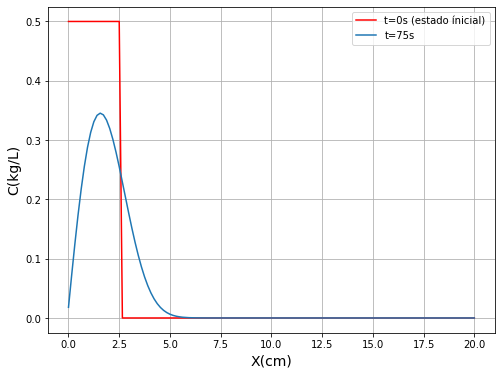

In [101]:
Tt = 75

x,u,init = CN(a=1, Nx=128, xi=0, xf=1,Tf=Tt, cond_inicial=initial_cond, cond_fronteira=fronteira,L=20,C0=0.5)

plt.figure(figsize=(8,6))
plt.plot(x,init,color='r',label='t=0s (estado ínicial)')
plt.plot(x,u,label=f't={Tt}s')

plt.xlabel('X(cm)',fontsize=14)
plt.ylabel('C(kg/L)',fontsize=14)

plt.legend()
plt.grid()
plt.show()

f) Possívelmente usou nas alíneas anteriores o _stencil_ de 5 pontos para descretizar o laplaciano, como fizémos nas aulas. Se pretendermos uma aproximação melhor, podemos usar a descretização do laplaciano com uma fórmula de 9 pontos em vez de 5. Uma possibilidade é: 
$$\nabla^2u\approx \frac{-20u_{i,j} + 4u_{i+1,j} + 4u_{i-1,j} + 4u_{i,j+1} + 4u_{i,j-1} + u_{i+1,j+1} + u_{i−1,j-1} + u_{i+1,j-1} + u_{i-1,j+1}}{6h^2},$$

que dá uma precisão $\mathcal{O}(h^4)$. No caso de usar um método de diferenças finitas, como se altera a matriz dos coeficientes? Escreva o comando para produzir os elementos apropriados usando o comando _spdiags_.

$$ \frac{U^{n+1}_{j,i} - U^n_{j,i}}{\Delta t}=  \big(\frac{-20u_{i,j} + 4u_{i+1,j} + 4u_{i-1,j} + 4u_{i,j+1} + 4u_{i,j-1} + u_{i+1,j+1} + u_{i−1,j-1} + u_{i+1,j-1} + u_{i-1,j+1}}{6\Delta x^2} \big)^{n+1} +  \big(\frac{-20u_{i,j} + 4u_{i+1,j} + 4u_{i-1,j} + 4u_{i,j+1} + 4u_{i,j-1} + u_{i+1,j+1} + u_{i−1,j-1} + u_{i+1,j-1} + u_{i-1,j+1}}{6 \Delta y^2} \big)^{n}$$

Sendo $\alpha_x=\frac{\Delta t}{6\Delta x^2}$ e $\alpha_y=\frac{\Delta t}{6\Delta y^2}$

